# ***ATTENZIONE***
In tutto il notebook gli outliers sono stati indicati con -1 all interno del dataset, gli inlier con 1.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from collections import Counter
from collections import defaultdict
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler

from pyod.models.hbos import HBOS

from sklearn.covariance import EllipticEnvelope

from pyod.models.knn import KNN

from sklearn.neighbors import LocalOutlierFactor

from pyod.models.cof import COF

from sklearn.cluster import DBSCAN

from pyod.models.cblof import CBLOF

from pyod.models.abod import ABOD

from pyod.models.loda import LODA

from sklearn.ensemble import IsolationForest
from pyod.models.iforest import IsolationForest

In [4]:
df_train=pd.read_csv("../ravdess_features_train_pulito.csv")
df_test=pd.read_csv("../ravdess_features_test_pulito.csv")

df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])
y_train=df_train.emotion.values
X_train=df_train.drop(columns=["emotion"]).values

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])
y_test=df_test.emotion.values
X_test=df_test.drop(columns=["emotion"]).values

In [5]:
frames = [df_train, df_test]
df = pd.concat(frames, ignore_index=True)
X = df.drop(columns=["emotion"]).values
X_unscaled = df.drop(columns=["emotion"]).values
y=df.emotion.values

In [6]:
sel = SelectKBest(k=108)
X = sel.fit_transform(X, y)

In [7]:
features = sel.get_feature_names_out()
features = ([s.replace("x", "") for s in features])
df.T.iloc[features].T.head()

vocal_channel  sex          mean       std       min       max       q01  \
0            0.0  0.0  9.150000e-07  0.004001 -0.038422  0.040588 -0.012586   
1            0.0  0.0  7.137790e-07  0.004283 -0.042603  0.048157 -0.013550   
2            0.0  0.0  9.554485e-07  0.005084 -0.037018  0.058472 -0.015822   
3            0.0  0.0  9.176213e-07  0.004886 -0.036652  0.062683 -0.014923   
4            0.0  0.0  8.108948e-07  0.002956 -0.026245  0.026215 -0.009399   

   q75       q95     lag1_mean  ...  mfcc_std_w3  mfcc_max_w3  mfcc_q01_w3  \
0  0.0  0.005676  0.000000e+00  ...   147.423418   240.630021  -734.485522   
1  0.0  0.005920  0.000000e+00  ...   144.564137   222.035063  -698.629767   
2  0.0  0.007263 -3.888704e-10  ...   144.489909   231.626338  -698.875743   
3  0.0  0.006470 -2.005743e-10  ...   144.062098   218.239004  -699.412515   
4  0.0  0.004242 -1.797605e-10  ...   144.892061   229.730841  -690.419475   

   mfcc_kur_w3  stft_skew_w3    std_w4    min_w4  lag1_std_w4  lag1_min_w4  \
0    14.901427      0.288573  0.000013 -0.000122     0.000011    -0.000061   
1    14.429526      0.513204  0.000018 -0.000244     0.000010    -0.000061   
2    14.459248      0.474012  0.000012 -0.000122     0.000009    -0.000092   
3    14.314860      0.239217  0.000024 -0.000244     0.000015    -0.000092   
4    13.218938      0.575065  0.000023 -0.000305     0.000013    -0.000061   

   zc_skew_w4  
0    3.922259  
1    4.613060  
2    5.079725  
3    3.369546  
4    3.937357  

[5 rows x 108 columns]

In [21]:
X.shape

(2452, 108)

In [22]:
scl = StandardScaler()
X = scl.fit_transform(X)

# Visual Based

## HBOS

In [23]:
clf = HBOS(n_bins=20)
clf.fit(X)
clf.decision_scores_

array([ 51.05939133,  47.26402508,  53.96083564, ..., 150.39595341,
       159.6243074 , 197.13622337])

In [24]:
outliers = clf.predict(X)
print(np.unique(outliers, return_counts=True))
print(np.unique(outliers, return_counts=True)[1][1]/len(X))

(array([0, 1]), array([2206,  246], dtype=int64))
0.100326264274062


In [25]:
for i in range(len(outliers)):
    if outliers[i] == 1:
        outliers[i] = -1
    else:
        outliers[i] = 1
outliers

array([1, 1, 1, ..., 1, 1, 1])

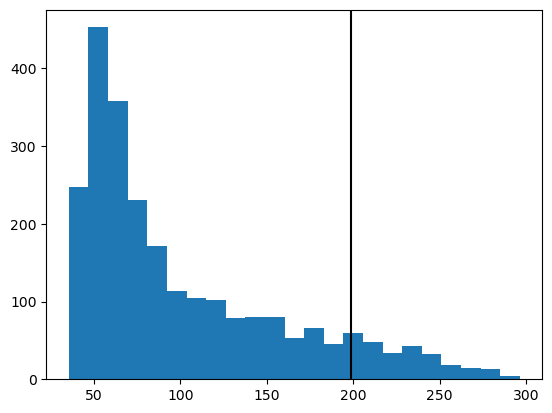

In [26]:
plt.hist(clf.decision_scores_, bins="auto")
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==-1)]), c='k')
plt.show()

# Depth Based

## Elliptic Envelope

In [27]:
ellenv = EllipticEnvelope(random_state=0)
ellenv.fit(X)
outliers = ellenv.predict(X)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-703.823911253811048 > -705.384128368961456). You may want to try with a higher value of support_fraction (current value: 0.523).
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-703.478325960850839 > -705.024772057926612). You may want to try with a higher value of support_fraction (current value: 0.523).
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not h

In [28]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 246, 2206], dtype=int64))

In [29]:
#df["outliers_elliptic_envelope"] = outliers

In [30]:
#df.iloc[np.where(df.outliers_elliptic_envelope == -1)].head()

# Distance Based

## KNN

In [31]:
clf = KNN(n_neighbors=2, method="largest", p=2, n_jobs=-1)
clf.fit(X)
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([2280,  172], dtype=int64))

In [32]:
for i in range(len(outliers)):
    if outliers[i] == 0:
        outliers[i] = 1
    else:
        outliers[i] = -1
outliers

array([1, 1, 1, ..., 1, 1, 1])

In [33]:
#df["outliers_knn"] = outliers

In [34]:
#df.iloc[np.where(df.outliers_knn == -1)].head()

In [35]:
'''
outliers_list_knn = []
for i in range(2,50):
    clf = KNN(n_neighbors=i, method="largest", p=2, n_jobs=-1)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_knn.append(np.unique(outliers, return_counts=True)[1][1])

plt.scatter(x=np.arange(2,50), y=outliers_list_knn)
plt.show()
'''
#tempo di esecuzione circa 2 minuti

'\noutliers_list_knn = []\nfor i in range(2,50):\n    clf = KNN(n_neighbors=i, method="largest", p=2, n_jobs=-1)\n    clf.fit(X)\n    outliers = clf.predict(X)\n    outliers_list_knn.append(np.unique(outliers, return_counts=True)[1][1])\n\nplt.scatter(x=np.arange(2,50), y=outliers_list_knn)\nplt.show()\n'

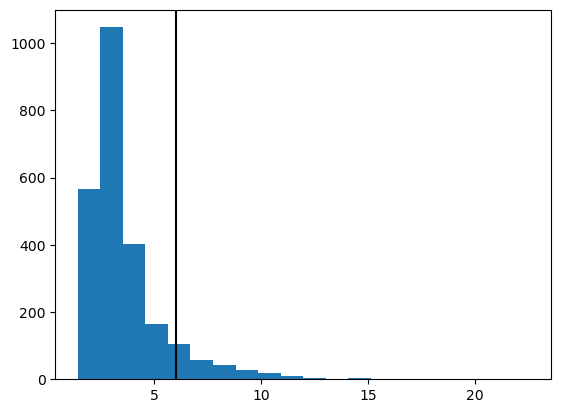

In [36]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==-1)]), c='k')
plt.show()

# Density Based

## LOF

In [37]:
'''
outliers_list_lof = []
for i in range(1,300):
    clf = LocalOutlierFactor(n_neighbors=i, novelty = False)
    clf.fit(X)
    outliers = clf.fit_predict(X)
    outliers_list_lof.append(np.unique(outliers, return_counts=True)[1][0])

plt.scatter(x=np.arange(1,300), y=outliers_list_lof)
plt.show()
'''
#tempo di esecuzione circa 2m40s. Minimo per n_neighbor=3 con 64 outliers

'\noutliers_list_lof = []\nfor i in range(1,300):\n    clf = LocalOutlierFactor(n_neighbors=i, novelty = False)\n    clf.fit(X)\n    outliers = clf.fit_predict(X)\n    outliers_list_lof.append(np.unique(outliers, return_counts=True)[1][0])\n\nplt.scatter(x=np.arange(1,300), y=outliers_list_lof)\nplt.show()\n'

In [38]:
clf = LocalOutlierFactor(n_neighbors=3, novelty = False, n_jobs=-1)
clf.fit(X)
outliers = clf.fit_predict(X)
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  43, 2409], dtype=int64))

In [39]:
NLOF = clf.negative_outlier_factor_ #the higher the more normal
ind = np.argpartition(NLOF, int(len(df)*0.01))[:int(len(df)*0.01)] # indice dei top 1% outliers
ind

array([1990, 2392,  899,  352,  234, 1970, 1981, 1879,  935, 1067,  698,
       2057, 1968, 1882,  815, 2375,  589, 1982, 1957, 1765, 2227, 1845,
       1815,  546], dtype=int64)

In [40]:
df["outliers_LOF"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_LOF"][i] = -1
    else:
        df["outliers_LOF"][i] = 1

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_14840\4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_14840\4215259980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = -1


In [41]:
df.iloc[np.where(df.outliers_LOF == -1)].head()

vocal_channel  emotion  emotional_intensity  statement  sex  frame_count  \
234              0        6                    1          0    0       166566   
352              0        0                    1          1    1       188989   
546              0        6                    1          0    1       221020   
589              1        5                    1          1    1       304304   
698              1        2                    0          0    0       208208   

          sum          mean       std       min  ...  stft_std_w4  \
234 -1.252472 -7.519373e-06  0.032619 -0.360992  ...     0.240487   
352 -0.173004 -9.154192e-07  0.041938 -0.357300  ...     0.297645   
546  0.617218  2.792589e-06  0.015362 -0.233215  ...     0.255465   
589 -0.247406 -8.130225e-07  0.007213 -0.038147  ...     0.244130   
698 -3.728546 -1.790779e-05  0.007680 -0.058197  ...     0.263412   

     stft_min_w4  stft_q01_w4  stft_q05_w4  stft_q25_w4  stft_q50_w4  \
234     0.034541     0.074704     0.218413     0.597664     0.792696   
352     0.026015     0.050132     0.074913     0.186668     0.375093   
546     0.012430     0.033260     0.111236     0.496639     0.676464   
589     0.000000     0.000000     0.000000     0.000000     0.000000   
698     0.032913     0.049182     0.114918     0.705369     0.851904   

     stft_q75_w4  stft_kur_w4  stft_skew_w4  outliers_LOF  
234     0.924666     0.156586     -0.969812            -1  
352     0.677906    -0.977898      0.520642            -1  
546     0.838886    -0.282704     -0.614345            -1  
589     0.007891     7.127631      2.880807            -1  
698     0.961261     1.077045     -1.457242            -1  

[5 rows x 378 columns]

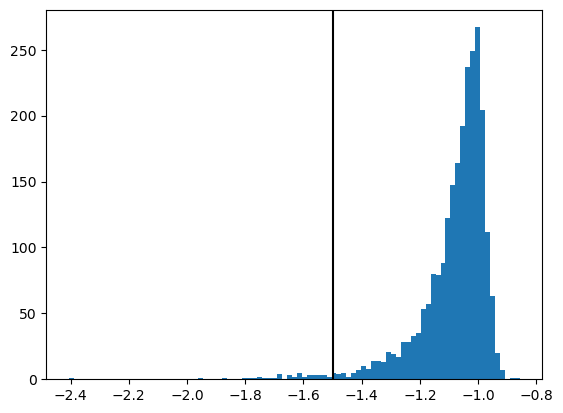

In [42]:
plt.hist(clf.negative_outlier_factor_, bins="auto")
plt.axvline(np.min(clf.negative_outlier_factor_[np.where(outliers==1)]), c='k')
plt.show()

## COF

In [43]:
clf = COF(n_neighbors=5)
clf.fit(X)
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([2206,  246], dtype=int64))

In [44]:
for i in range(len(outliers)):
    if outliers[i] == 0:
        outliers[i] = 1
    else:
        outliers[i] = -1
outliers

array([1, 1, 1, ..., 1, 1, 1])

In [45]:
#df["outliers_cof"] = outliers

In [46]:
#df.iloc[np.where(df.outliers_cof == -1)]

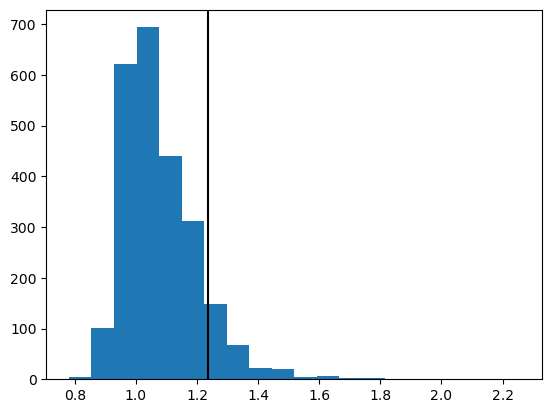

In [47]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==-1)]), c='k')
plt.show()

# Cluster Based

## DBSCAN

In [48]:
outliers=[]
for i in range(1,20):    
    dbscan = DBSCAN(eps=i, min_samples=5)
    dbscan.fit(X)
    outliers.append((dbscan.labels_==-1).sum())

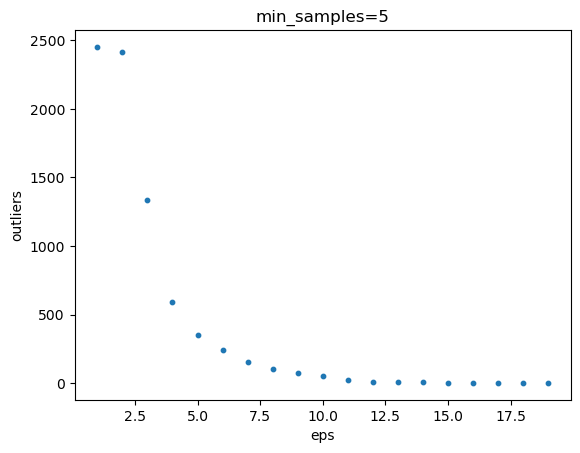

In [49]:
plt.scatter(x=range(1,20), y=outliers, s=10)
plt.xlabel("eps")
plt.ylabel("outliers")
plt.title("min_samples=5")
plt.show()

## CBLOF

In [50]:

outliers_list_cblof = []
for i in range(3,30):
    clf = CBLOF(n_clusters=i, alpha=0.75, beta=3)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_cblof.append(np.unique(outliers, return_counts=True)[1][1])

outliers_list_cblof


[246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246]

In [51]:
OS = clf.decision_scores_ #the lower the more normal
ind = np.argpartition(OS, -int(len(df)*0.01))[-int(len(df)*0.01):] # indice dei top 1% outliers
ind

array([1031,  552, 1974,  451, 1029, 2235,  658,  659, 2027,   35, 2026,
       1283, 1966, 1862, 1861,  554,  243, 1075, 1801, 1802, 1803, 2025,
       2024,  563], dtype=int64)

In [52]:
df["outliers_CBLOF"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_CBLOF"][i] = -1
    else:
        df["outliers_CBLOF"][i] = 1

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_14840\3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_14840\3000840312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = -1


In [53]:
df.iloc[np.where(df.outliers_CBLOF == -1)].head()

vocal_channel  emotion  emotional_intensity  statement  sex  frame_count  \
35               0        1                    1          0    0       213013   
243              0        1                    1          0    0       216216   
451              0        1                    1          0    0       174575   
552              0        1                    1          1    1       196997   
554              0        1                    1          0    1       213013   

          sum      mean       std       min  ...  stft_min_w4  stft_q01_w4  \
35  -9.211029 -0.000043  0.149701 -0.971649  ...     0.035675     0.070545   
243 -0.476227 -0.000002  0.104572 -0.944122  ...     0.078238     0.115917   
451  0.947906  0.000005  0.109958 -0.938812  ...     0.118842     0.213265   
552  0.263824  0.000001  0.116608 -0.799988  ...     0.006342     0.024296   
554  0.785797  0.000004  0.091451 -0.633057  ...     0.005593     0.016566   

     stft_q05_w4  stft_q25_w4  stft_q50_w4  stft_q75_w4  stft_kur_w4  \
35      0.122659     0.292612     0.484957     0.751114    -1.098503   
243     0.221915     0.466304     0.629270     0.809098    -0.688100   
451     0.291577     0.438643     0.598260     0.777178    -0.912299   
552     0.087120     0.342602     0.584946     0.780867    -1.003872   
554     0.041669     0.294650     0.659654     0.854806    -1.151544   

     stft_skew_w4  outliers_LOF  outliers_CBLOF  
35       0.225204             1              -1  
243     -0.164156             1              -1  
451      0.219962             1              -1  
552     -0.118170             1              -1  
554     -0.429745             1              -1  

[5 rows x 379 columns]

In [54]:
outliers

array([0, 0, 0, ..., 0, 0, 0])

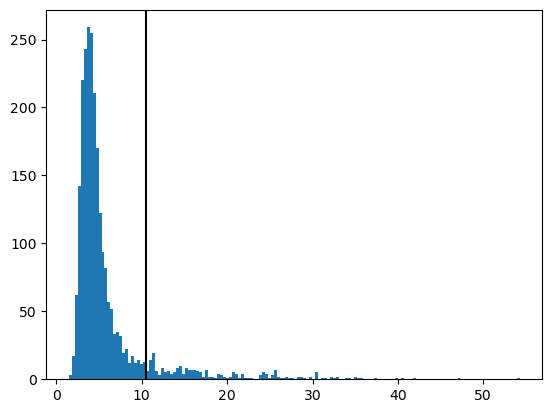

In [55]:
plt.hist(clf.decision_scores_, bins="auto")
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# Angle Based

## ABOD

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


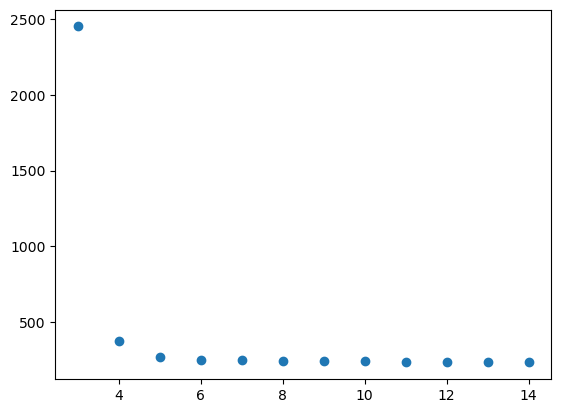

In [56]:

outliers_list_abod = []
for i in range(3,15):
    clf = ABOD(n_neighbors=i)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_abod.append(np.unique(outliers, return_counts=True)[1][1])

plt.scatter(x=np.arange(3,15), y=outliers_list_abod)
plt.show()


In [ ]:
np.unique(outliers, return_counts=True)

In [57]:
OS = clf.decision_scores_ #the lower the more normal
ind = np.argpartition(OS, -int(len(df)*0.01))[-int(len(df)*0.01):] # indice dei top 1% outliers
ind

array([1757,  761,  241, 1878, 1975, 1964, 2025, 2024,  555,  554, 2027,
       1031,  346, 1075,  658,  563, 2026,  243, 1283,  659,   35, 1861,
       1862,  234], dtype=int64)

In [58]:
df["outliers_ABOD"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_ABOD"][i] = -1
    else:
        df["outliers_ABOD"][i] = 1

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_14840\3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_14840\3807823159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = -1


In [59]:
df.iloc[np.where(df.outliers_ABOD == -1)]

vocal_channel  emotion  emotional_intensity  statement  sex  \
35                0        1                    1          0    0   
234               0        6                    1          0    0   
241               0        1                    1          1    0   
243               0        1                    1          0    0   
346               0        1                    1          0    1   
554               0        1                    1          0    1   
555               0        1                    1          0    1   
563               0        0                    1          0    1   
658               0        1                    1          0    0   
659               0        1                    1          0    0   
761               0        1                    1          1    1   
1031              1        1                    1          0    1   
1075              0        1                    1          0    0   
1283              0        1                    1          0    0   
1757              1        1                    1          1    0   
1861              0        1                    1          1    0   
1862              0        1                    1          0    0   
1878              0        7                    1          0    0   
1964              0        1                    1          1    1   
1975              0        0                    1          0    1   
2024              1        1                    1          1    1   
2025              1        1                    1          1    1   
2026              1        1                    1          0    1   
2027              1        1                    1          0    1   

      frame_count        sum          mean       std       min  ...  \
35         213013  -9.211029 -4.324163e-05  0.149701 -0.971649  ...   
234        166566  -1.252472 -7.519373e-06  0.032619 -0.360992  ...   
241        211412   7.284607  3.445692e-05  0.087604 -0.998810  ...   
243        216216  -0.476227 -2.202551e-06  0.104572 -0.944122  ...   
346        177777  -0.004974 -2.798093e-08  0.072248 -0.862366  ...   
554        213013   0.785797  3.688963e-06  0.091451 -0.633057  ...   
555        214614   0.211212  9.841490e-07  0.088013 -0.676880  ...   
563        179379  -0.203125 -1.132379e-06  0.121231 -0.727966  ...   
658        184184  -6.383972 -3.466084e-05  0.120286 -0.976166  ...   
659        208208   2.806671  1.348013e-05  0.096210 -0.763763  ...   
761        180981  -9.155212 -5.058659e-05  0.095456 -0.971954  ...   
1031       219420   0.905365  4.126174e-06  0.091933 -0.561218  ...   
1075       180981   8.481720  4.686525e-05  0.104275 -0.939880  ...   
1283       200200  -3.701965 -1.849134e-05  0.152168 -0.970276  ...   
1757       229029 -23.250671 -1.015185e-04  0.095393 -0.654694  ...   
1861       230630   2.317932  1.005044e-05  0.104134 -0.743408  ...   
1862       208208  -0.817017 -3.924040e-06  0.140110 -0.998810  ...   
1878       235435  -1.745026 -7.411921e-06  0.035706 -0.355957  ...   
1964       198599   0.315552  1.588889e-06  0.034097 -0.488007  ...   
1975       187388  -4.495575 -2.399073e-05  0.125805 -0.987640  ...   
2024       217818  -0.678925 -3.116935e-06  0.114889 -0.616730  ...   
2025       217817  -0.129700 -5.954526e-07  0.091525 -0.618561  ...   
2026       217818   0.193146  8.867300e-07  0.118097 -0.732819  ...   
2027       219419   0.656555  2.992244e-06  0.108406 -0.730164  ...   

      stft_q01_w4  stft_q05_w4  stft_q25_w4  stft_q50_w4  stft_q75_w4  \
35       0.070545     0.122659     0.292612     0.484957     0.751114   
234      0.074704     0.218413     0.597664     0.792696     0.924666   
241      0.119145     0.266537     0.520887     0.692956     0.856511   
243      0.115917     0.221915     0.466304     0.629270     0.809098   
346      0.289735     0.371105     0.554598     0.702927     0.851481   
554      0.016566     0.041669     0.294650     0.659654     0.854

In [60]:
'''plt.hist(clf.decision_scores_, bins="auto")
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.xlim((-3e-5,0.2e-5))
plt.show()'''

'plt.hist(clf.decision_scores_, bins="auto")\nplt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c=\'k\')\nplt.xlim((-3e-5,0.2e-5))\nplt.show()'

# Ensemble Based

## LODA

In [61]:

outliers_list_loda = []
for i in range(1,30):
    clf = LODA(n_bins="auto", n_random_cuts=i)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_loda.append(np.unique(outliers, return_counts=True)[1][1])


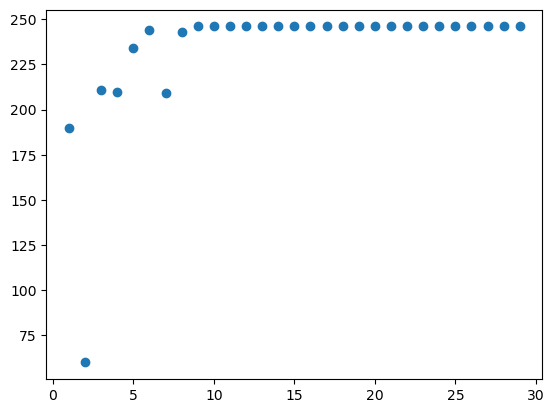

In [62]:
plt.scatter(x=np.arange(1,30), y=outliers_list_loda)
plt.show()

In [63]:
OS = clf.decision_scores_ #the lower the more normal
ind = np.argpartition(OS, -int(len(df)*0.01))[-int(len(df)*0.01):] # indice dei top 1% outliers
ind

array([1030,  242,  346,  563, 2235, 1029,  451,  450, 1283, 2024,  954,
        553, 2027,  243,  240, 2338, 2026,   35,  659, 2025, 1861, 1878,
       1862,  554], dtype=int64)

In [64]:
df["outliers_LODA"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_LODA"][i] = -1
    else:
        df["outliers_LODA"][i] = 1

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_14840\825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_14840\825742444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = -1


In [65]:
df.iloc[np.where(df.outliers_LODA == -1)]

vocal_channel  emotion  emotional_intensity  statement  sex  \
35                0        1                    1          0    0   
240               0        1                    1          1    0   
242               0        1                    1          0    0   
243               0        1                    1          0    0   
346               0        1                    1          0    1   
450               0        1                    1          0    0   
451               0        1                    1          0    0   
553               0        1                    1          1    1   
554               0        1                    1          0    1   
563               0        0                    1          0    1   
659               0        1                    1          0    0   
954               0        2                    1          0    1   
1029              1        1                    1          1    1   
1030              1        1                    1          0    1   
1283              0        1                    1          0    0   
1861              0        1                    1          1    0   
1862              0        1                    1          0    0   
1878              0        7                    1          0    0   
2024              1        1                    1          1    1   
2025              1        1                    1          1    1   
2026              1        1                    1          0    1   
2027              1        1                    1          0    1   
2235              1        1                    1          0    1   
2338              1        1                    1          0    0   

      frame_count       sum          mean       std       min  ...  \
35         213013 -9.211029 -4.324163e-05  0.149701 -0.971649  ...   
240        211411 -4.979034 -2.355144e-05  0.089317 -0.963928  ...   
242        203403 -0.531708 -2.614061e-06  0.079331 -0.789062  ...   
243        216216 -0.476227 -2.202551e-06  0.104572 -0.944122  ...   
346        177777 -0.004974 -2.798093e-08  0.072248 -0.862366  ...   
450        174574 -1.441101 -8.254958e-06  0.108910 -0.986420  ...   
451        174575  0.947906  5.429795e-06  0.109958 -0.938812  ...   
553        201801  2.821381  1.398100e-05  0.104772 -0.734375  ...   
554        213013  0.785797  3.688963e-06  0.091451 -0.633057  ...   
563        179379 -0.203125 -1.132379e-06  0.121231 -0.727966  ...   
659        208208  2.806671  1.348013e-05  0.096210 -0.763763  ...   
954        179379  0.116943  6.519345e-07  0.123267 -0.902740  ...   
1029       232232  1.184143  5.098966e-06  0.099392 -0.693817  ...   
1030       219419  0.254578  1.160235e-06  0.099819 -0.867523  ...   
1283       200200 -3.701965 -1.849134e-05  0.152168 -0.970276  ...   
1861       230630  2.317932  1.005044e-05  0.104134 -0.743408  ...   
1862       208208 -0.817017 -3.924040e-06  0.140110 -0.998810  ...   
1878       235435 -1.745026 -7.411921e-06  0.035706 -0.355957  ...   
2024       217818 -0.678925 -3.116935e-06  0.114889 -0.616730  ...   
2025       217817 -0.129700 -5.954526e-07  0.091525 -0.618561  ...   
2026       217818  0.193146  8.867300e-07  0.118097 -0.732819  ...   
2027       219419  0.656555  2.992244e-06  0.108406 -0.730164  ...   
2235       227427 -1.169708 -5.143225e-06  0.102923 -0.642151  ...   
2338       224224 -0.284241 -1.267664e-06  0.065562 -0.592102  ...   

      stft_q05_w4  stft_q25_w4  stft_q50_w4  stft_q75_w4  stft_kur_w4  \
35       0.122659     0.292612     0.484957     0.751114    -1.098503   
240      0.232051     0.517947     0.706479     0.873016    -0.566148   
242      0.186420     0.386916     0.549717     0.759995    -0.884069   
243      0.221915     0.466304     0.629270     0.809098    -0.688100   
346      0.371105     0.554598     0.702927     0.851481    -0.856788   
450      0.251861     0.554605     0.710325     0.860453    -0.426448   
451      0.291577 

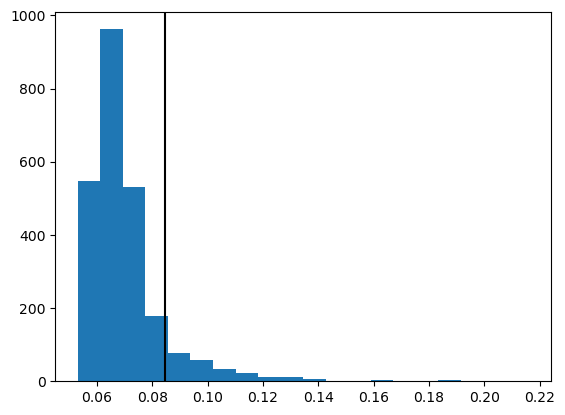

In [66]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# Model Based

## Isolation Forest

In [67]:
'''
outliers_list_isoforest = []
for i in range(1,110):
    clf = IsolationForest(random_state=0, n_jobs=-1, n_estimators=i)
    clf.fit(X_train)
    outliers = clf.predict(X_test)
    outliers_list_isoforest.append(np.unique(outliers, return_counts=True)[1][0])

plt.scatter(x=np.arange(1,110), y=outliers_list_isoforest)
plt.show()
'''

'\noutliers_list_isoforest = []\nfor i in range(1,110):\n    clf = IsolationForest(random_state=0, n_jobs=-1, n_estimators=i)\n    clf.fit(X_train)\n    outliers = clf.predict(X_test)\n    outliers_list_isoforest.append(np.unique(outliers, return_counts=True)[1][0])\n\nplt.scatter(x=np.arange(1,110), y=outliers_list_isoforest)\nplt.show()\n'

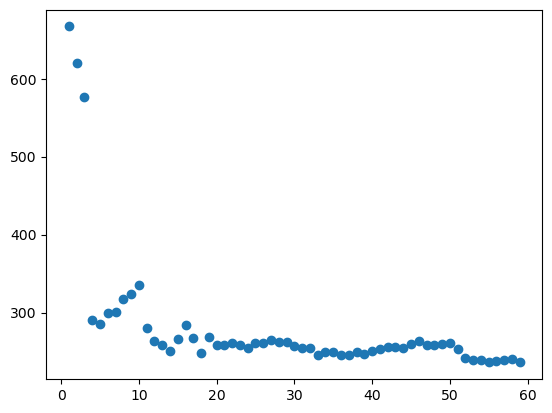

In [68]:
outliers_list_isoforest = []
for i in range(1,60):
    clf = IsolationForest(random_state=0, n_jobs=-1, n_estimators=i)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_isoforest.append(np.unique(outliers, return_counts=True)[1][0])

plt.scatter(x=np.arange(1,60), y=outliers_list_isoforest)
plt.show()

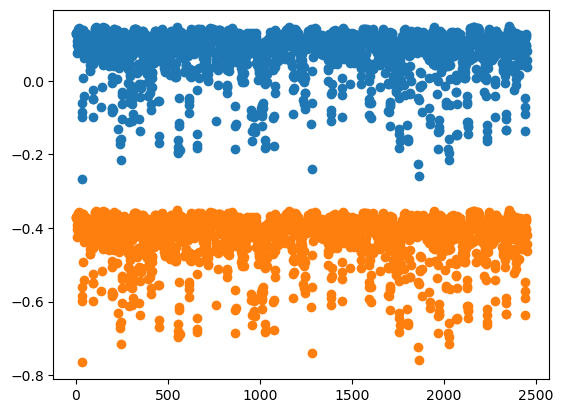

In [69]:
plt.scatter(x=np.arange(0,len(clf.decision_function(X))), y=clf.decision_function(X))
plt.scatter(x=np.arange(0,len(clf.score_samples(X))), y=clf.score_samples(X))
plt.show()
# questo vuol dire che le due funzioni vogliono dire la stessa cosa, ma decision_function è centrato attorno a zero

In [70]:
clf = IsolationForest(random_state=0, n_jobs=-1, n_estimators=35)
clf.fit(X)
outliers = clf.predict(X)

In [71]:
OS = clf.decision_function(X) #the higher the more normal
ind = np.argpartition(OS, int(len(df)*0.01))[:int(len(df)*0.01)] # indice dei top 1% outliers
ind

array([ 243, 1075, 1862, 1283, 1861, 1757, 2027,   35,  553, 2026,  658,
        554,  451, 1966,  563, 2024, 2025, 1759,  659,  866, 1031,  552,
        450,  240], dtype=int64)

In [72]:
OS, OS[35], OS[np.where(OS < 0)] #Outliers have decision_function values less than 0

(array([0.13456227, 0.13240853, 0.13477001, ..., 0.06521561, 0.05918829,
        0.03884961]),
 -0.26437144587035744,
 array([-0.09701014, -0.05509297, -0.08672578, -0.26437145, -0.04183315,
        -0.01509023, -0.05775363, -0.04320507, -0.08639876, -0.06762265,
        -0.02101517, -0.08939482, -0.07099159, -0.07768142, -0.08063334,
        -0.13064062, -0.1675337 , -0.15822254, -0.15275308, -0.21961213,
        -0.04216056, -0.09579556, -0.05877618, -0.06631401, -0.02498228,
        -0.06345029, -0.05283461, -0.1277754 , -0.02046736, -0.00314675,
        -0.03922994, -0.06693458, -0.12142414, -0.0785427 , -0.01566999,
        -0.08103021, -0.0461107 , -0.02980458, -0.12354931, -0.00250329,
        -0.13467467, -0.05473676, -0.01955499, -0.02733119, -0.02922481,
        -0.00848226, -0.05691807, -0.03091654, -0.02158041, -0.08982818,
        -0.10500469, -0.00330814, -0.07534637, -0.08544411, -0.16853438,
        -0.18625784, -0.17162963, -0.19933584, -0.18829643, -0.15997038,
      

In [73]:
df["outliers_ISOFOREST"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_ISOFOREST"][i] = -1
    else:
        df["outliers_ISOFOREST"][i] = 1

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_14840\2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_14840\2040245743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = -1


In [74]:
df.iloc[np.where(df.outliers_ISOFOREST == -1)].head()

vocal_channel  emotion  emotional_intensity  statement  sex  frame_count  \
35               0        1                    1          0    0       213013   
240              0        1                    1          1    0       211411   
243              0        1                    1          0    0       216216   
450              0        1                    1          0    0       174574   
451              0        1                    1          0    0       174575   

          sum      mean       std       min  ...  stft_q25_w4  stft_q50_w4  \
35  -9.211029 -0.000043  0.149701 -0.971649  ...     0.292612     0.484957   
240 -4.979034 -0.000024  0.089317 -0.963928  ...     0.517947     0.706479   
243 -0.476227 -0.000002  0.104572 -0.944122  ...     0.466304     0.629270   
450 -1.441101 -0.000008  0.108910 -0.986420  ...     0.554605     0.710325   
451  0.947906  0.000005  0.109958 -0.938812  ...     0.438643     0.598260   

     stft_q75_w4  stft_kur_w4  stft_skew_w4  outliers_LOF  outliers_CBLOF  \
35      0.751114    -1.098503      0.225204             1              -1   
240     0.873016    -0.566148     -0.498224             1               1   
243     0.809098    -0.688100     -0.164156             1              -1   
450     0.860453    -0.426448     -0.496453             1               1   
451     0.777178    -0.912299      0.219962             1              -1   

     outliers_ABOD  outliers_LODA  outliers_ISOFOREST  
35              -1             -1                  -1  
240              1             -1                  -1  
243             -1             -1                  -1  
450              1             -1                  -1  
451              1             -1                  -1  

[5 rows x 382 columns]

# Statistical approach

## Grubb's test

In [75]:
len(X)

2452

In [76]:
n = X.shape[0]
data = []
feature = 93
for i in range(X.shape[0]):
    data.append(X_unscaled[i][feature])
print(len(data))

2452


In [77]:
data = np.array(data)

In [78]:
alpha = 0.95
significance_level = alpha/(2*n)
1-significance_level

0.9998062805872757

In [79]:
t = stats.t.isf(significance_level, n-2, 2)
t

5.553422986562849

In [80]:
g_test = ((n-1) / np.sqrt(n)) * (np.sqrt(t**2 / (n-2 + t**2)))
g_test

5.518796874855831

In [81]:
relative_values = abs(data - data.mean())
index = relative_values.argmax()
value = relative_values[index]

In [82]:
g = value/data.std()

In [83]:
if g > g_test:
    print('outlier')
else:
    print('inlier')

outlier


## Likelihood Approach

In [84]:
def norm_dist(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.e**(-((x-mu)**2)/(2*sigma**2))
              
def unif_dist(x, n):
    return 1/n

In [85]:
data = []
feature = 187
for i in range(X.shape[0]):
    data.append(X_unscaled[i][feature])
print(len(data))

2452


In [86]:
M = np.copy(data)
A = []
lambda_par = 0.3

muM = np.mean(M)
sigmaM = np.std(M)
sizeA = len(A)

sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])

sumA = np.sum([unif_dist(x, sizeA) for x in A])

ll = (len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)

In [87]:
M = np.copy(data)
A = []
c = 13656
for i, x in enumerate(data):
    A.append(x)
    M = np.array([xo for j, xo in enumerate(data) if i!=j])
    muM = np.mean(M)
    sigmaM = np.std(M)
    sizeA = len(A)
    sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])
    sumA = np.sum([unif_dist(x, sizeA) for x in A])
    ll_xi = (len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)
    delta_ll = abs(ll - ll_xi)
    print(i, delta_ll, 'outlier' if delta_ll > c else 'inlier')
    M = np.copy(data)
    A = list()

0 0.0452272215765106 inlier
1 0.04017383742814218 inlier
2 0.06436530982966815 inlier
3 0.04342266888158974 inlier
4 0.0410258039519249 inlier
5 0.10494004972360926 inlier
6 0.04037279346232481 inlier
7 0.05570597193616322 inlier
8 0.07797482469356964 inlier
9 0.041430656073885075 inlier
10 0.048098657618311336 inlier
11 0.04332772780151117 inlier
12 0.040575995967515155 inlier
13 0.07422377295722526 inlier
14 0.040078239469721666 inlier
15 0.04000332522991812 inlier
16 0.040826984365708086 inlier
17 0.04001808644295579 inlier
18 0.0446575122654167 inlier
19 0.04657075253282983 inlier
20 0.047122896075848075 inlier
21 0.04181452761019955 inlier
22 0.06240669336989413 inlier
23 0.04016455379985473 inlier
24 0.04003030001672414 inlier
25 0.040989281775750896 inlier
26 0.04222591129916964 inlier
27 0.04292660656119551 inlier
28 0.0536701861013853 inlier
29 0.06189202985569864 inlier
30 0.06568432497340382 inlier
31 0.0818637545820593 inlier
32 0.06559514565708469 inlier
33 0.0558514339132

# Deviation Based

In [88]:
def sf(x, X):
    idx = list(X).index(x)
    X1 = np.array([x1 for i, x1 in enumerate(X) if i != idx])
    return np.abs(np.var(X) - np.var(X1))

In [89]:
for i, x in enumerate(data):
    print(i, sf(x, data))

0 0.006634128293200092
1 0.0075302294861003816
2 0.0054470109852893245
3 0.007496136440497736
4 0.007647492112759835
5 0.0003617979931505033
6 0.0074772407524434925
7 0.006363050532275594
8 0.003882245030055742
9 0.007262402275458157
10 0.006189152188476044
11 0.0069377937576931
12 0.007661172115227544
13 0.004327797439600545
14 0.00756252583481043
15 0.007609091685171876
16 0.00765487198350101
17 0.0076301209431868244
18 0.006724023505967125
19 0.006424646576643767
20 0.007188140033740353
21 0.007193437725355523
22 0.005660065703523287
23 0.007533047634147749
24 0.007584632599691332
25 0.007345708263340356
26 0.007121892723667145
27 0.0070038367611751084
28 0.005337944097384195
29 0.00406738508736737
30 0.00346791178107253
31 0.0007753227275024699
32 0.0034821280489971684
33 0.005003846859114702
34 0.00399172570071471
35 0.0011574804011758033
36 0.004088755606726835
37 0.007518148990197204
38 0.007241127031768713
39 0.002859103638524374
40 0.0001685410248342123
41 0.004754988181996822

In [90]:
np.var(data)

18.780668583603553

# Outliers Visualization through Dimensionality Reduction

In [91]:
df.head()

vocal_channel  emotion  emotional_intensity  statement  sex  frame_count  \
0              0        4                    0          1    0       158558   
1              0        4                    0          1    0       160160   
2              0        4                    0          0    0       156956   
3              0        4                    0          0    0       152152   
4              0        5                    0          1    0       169769   

        sum          mean       std       min  ...  stft_q25_w4  stft_q50_w4  \
0  0.145081  9.150000e-07  0.004001 -0.038422  ...     0.709962     0.799141   
1  0.114319  7.137790e-07  0.004283 -0.042603  ...     0.623183     0.744908   
2  0.149963  9.554485e-07  0.005084 -0.037018  ...     0.643636     0.774253   
3  0.139618  9.176213e-07  0.004886 -0.036652  ...     0.606910     0.755213   
4  0.137665  8.108948e-07  0.002956 -0.026245  ...     0.634815     0.759914   

   stft_q75_w4  stft_kur_w4  stft_skew_w4  outliers_LOF  outliers_CBLOF  \
0     0.896606     6.742190     -1.706215             1               1   
1     0.874713    -0.700420     -0.201495             1               1   
2     0.899156     1.688986     -1.024773             1               1   
3     0.886474    -0.594111     -0.412871             1               1   
4     0.878014     0.126535     -0.620782             1               1   

   outliers_ABOD  outliers_LODA  outliers_ISOFOREST  
0              1              1                   1  
1              1              1                   1  
2              1              1                   1  
3              1              1                   1  
4              1              1                   1  

[5 rows x 382 columns]

## ISOMAP

In [92]:
from sklearn.manifold import Isomap

In [93]:
iso = Isomap(n_components=2, n_jobs=-1)
X_iso = iso.fit_transform(X)
X_iso.shape

(2452, 2)

### LOF

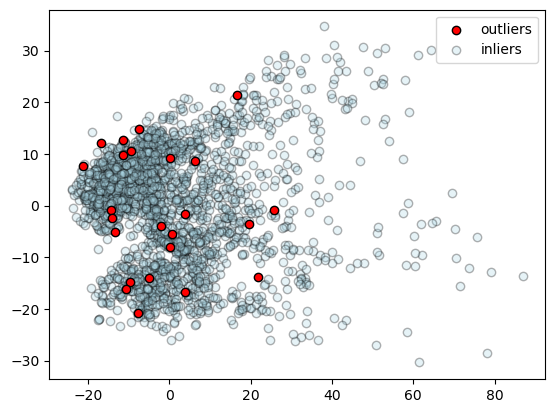

In [127]:
plt.scatter(X_iso[np.where(df.outliers_LOF == -1), 0], X_iso[np.where(df.outliers_LOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red", zorder=2)
plt.scatter(X_iso[np.where(df.outliers_LOF == 1), 0], X_iso[np.where(df.outliers_LOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue", zorder=1)
plt.legend()
plt.show()

### CBLOF

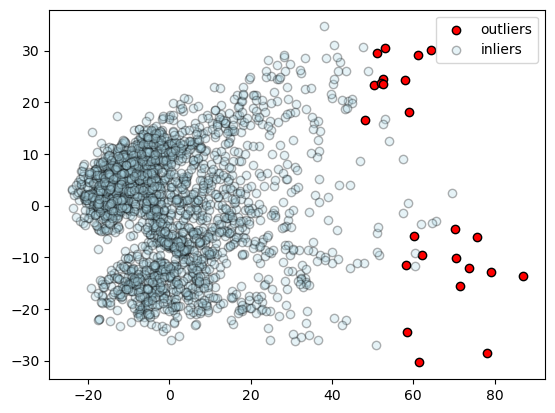

In [95]:
plt.scatter(X_iso[np.where(df.outliers_CBLOF == -1), 0], X_iso[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_CBLOF == 1), 0], X_iso[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

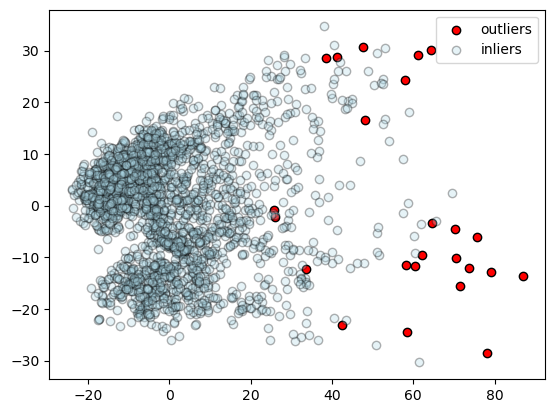

In [96]:
plt.scatter(X_iso[np.where(df.outliers_ABOD == -1), 0], X_iso[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_ABOD == 1), 0], X_iso[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

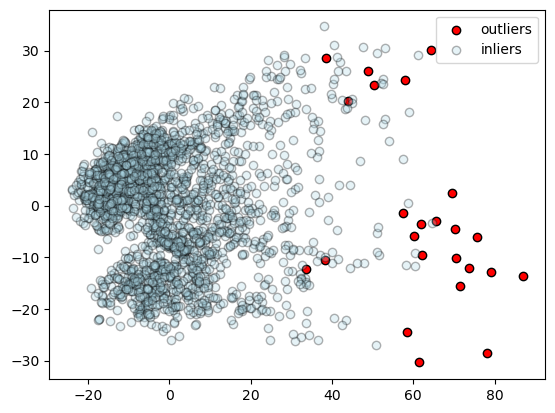

In [97]:
plt.scatter(X_iso[np.where(df.outliers_LODA == -1), 0], X_iso[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_LODA == 1), 0], X_iso[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

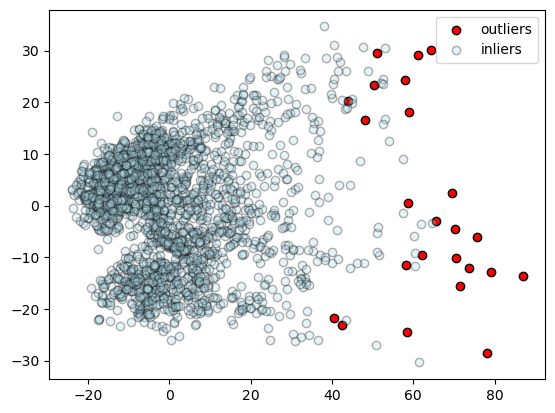

In [98]:
plt.scatter(X_iso[np.where(df.outliers_ISOFOREST == -1), 0], X_iso[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_ISOFOREST == 1), 0], X_iso[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

## T-SNE

In [99]:
from sklearn.manifold import TSNE

In [100]:
tsne = TSNE(n_components=2, learning_rate="auto", init="pca", n_jobs=-1)
X_tsne = tsne.fit_transform(X)
X_tsne.shape

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(2452, 2)

### LOF

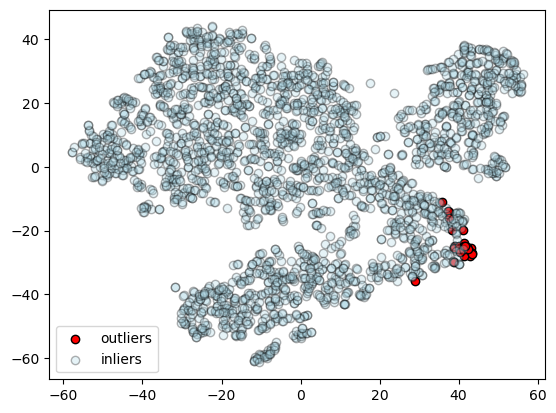

In [101]:
plt.scatter(X_tsne[np.where(df.outliers_LODA == -1), 0], X_tsne[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_LODA == 1), 0], X_tsne[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### CBLOF

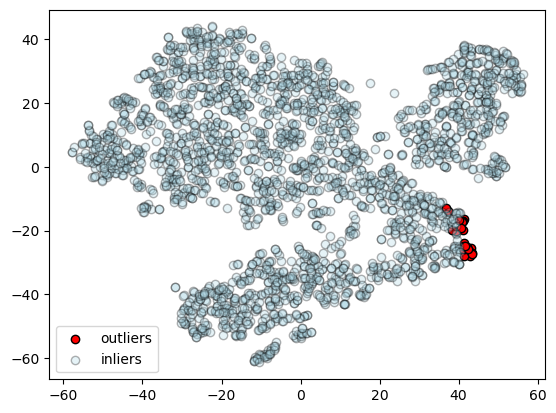

In [102]:
plt.scatter(X_tsne[np.where(df.outliers_CBLOF == -1), 0], X_tsne[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_CBLOF == 1), 0], X_tsne[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

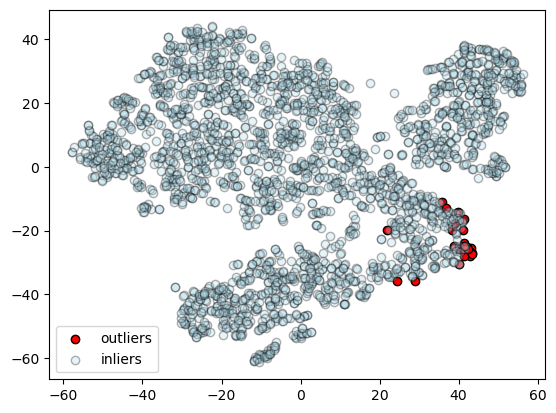

In [103]:
plt.scatter(X_tsne[np.where(df.outliers_ABOD == -1), 0], X_tsne[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_ABOD == 1), 0], X_tsne[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

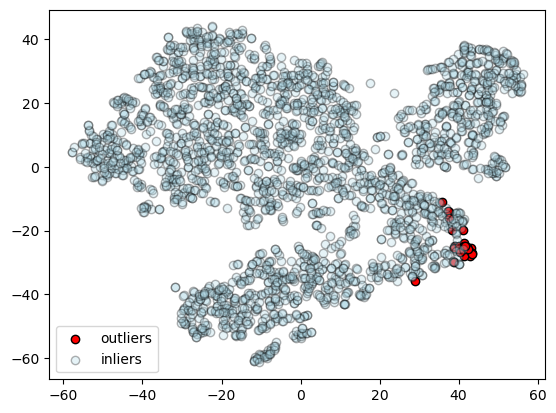

In [104]:
plt.scatter(X_tsne[np.where(df.outliers_LODA == -1), 0], X_tsne[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_LODA == 1), 0], X_tsne[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

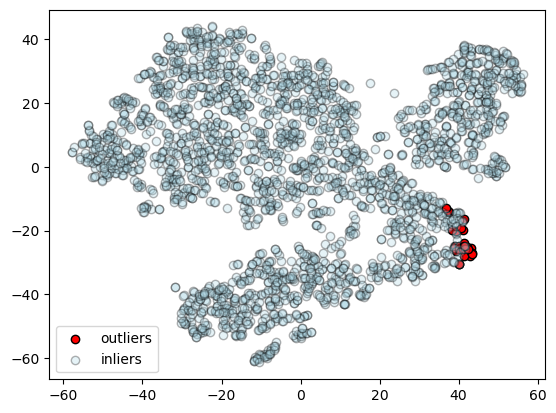

In [105]:
plt.scatter(X_tsne[np.where(df.outliers_ISOFOREST == -1), 0], X_tsne[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_ISOFOREST == 1), 0], X_tsne[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

## Multi Dimensional Scaling

In [106]:
from sklearn.manifold import MDS

In [107]:
mds = MDS(n_components=2, n_jobs=-1) #, normalized_stress='auto') # shoudl run as sammon mapping
X_mds = mds.fit_transform(X)
X_mds.shape

(2452, 2)

### LOF

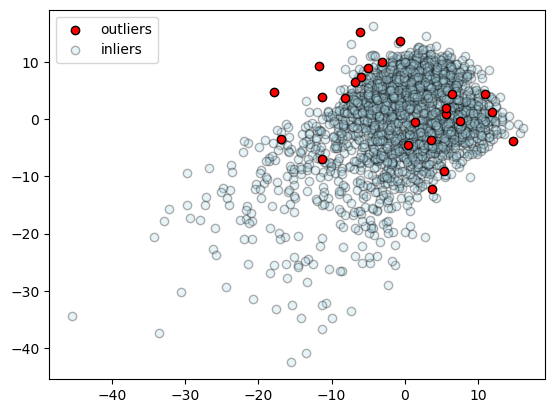

In [128]:
plt.scatter(X_mds[np.where(df.outliers_LOF == -1), 0], X_mds[np.where(df.outliers_LOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red", zorder=2)
plt.scatter(X_mds[np.where(df.outliers_LOF == 1), 0], X_mds[np.where(df.outliers_LOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue", zorder=1)
plt.legend()
plt.show()

### CBLOF

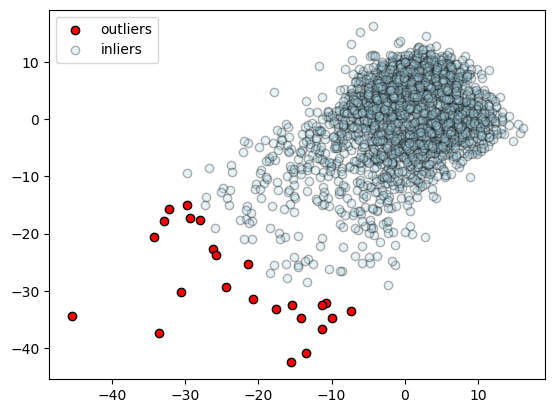

In [109]:
plt.scatter(X_mds[np.where(df.outliers_CBLOF == -1), 0], X_mds[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_CBLOF == 1), 0], X_mds[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

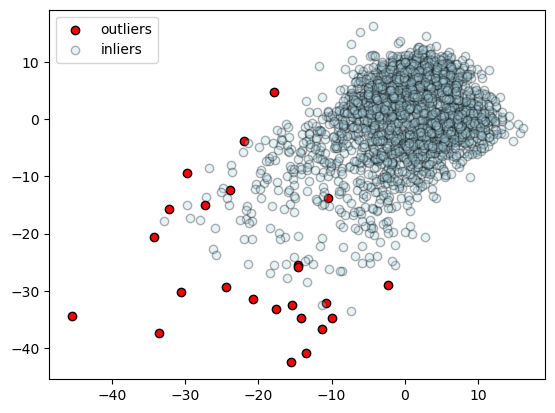

In [110]:
plt.scatter(X_mds[np.where(df.outliers_ABOD == -1), 0], X_mds[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_ABOD == 1), 0], X_mds[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

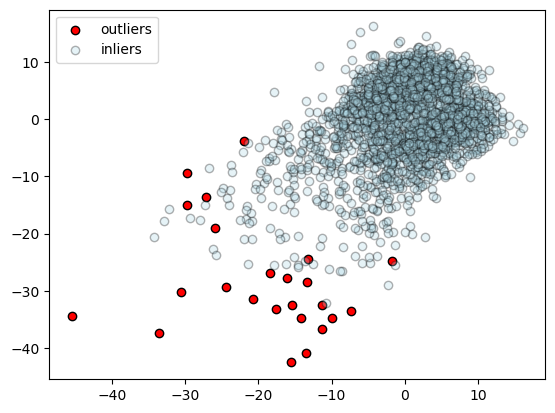

In [111]:
plt.scatter(X_mds[np.where(df.outliers_LODA == -1), 0], X_mds[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_LODA == 1), 0], X_mds[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

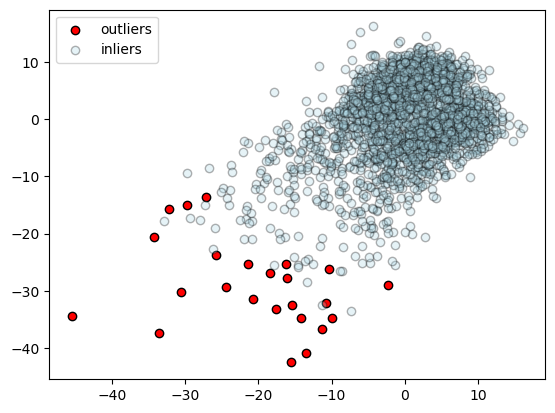

In [112]:
plt.scatter(X_mds[np.where(df.outliers_ISOFOREST == -1), 0], X_mds[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_ISOFOREST == 1), 0], X_mds[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

## Principal Component Analysis

In [113]:
from sklearn.decomposition import PCA

In [114]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

### LOF

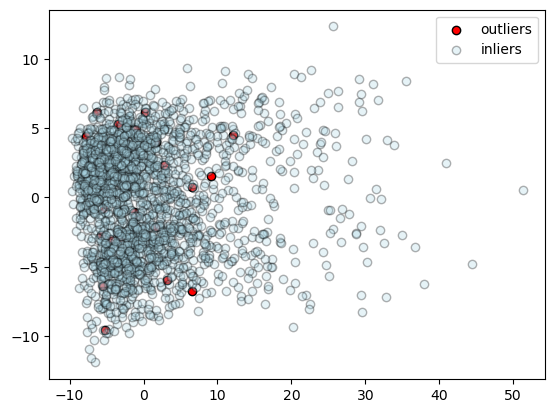

In [115]:
plt.scatter(X_pca[np.where(df.outliers_LOF == -1), 0], X_pca[np.where(df.outliers_LOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_LOF == 1), 0], X_pca[np.where(df.outliers_LOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### CBLOF

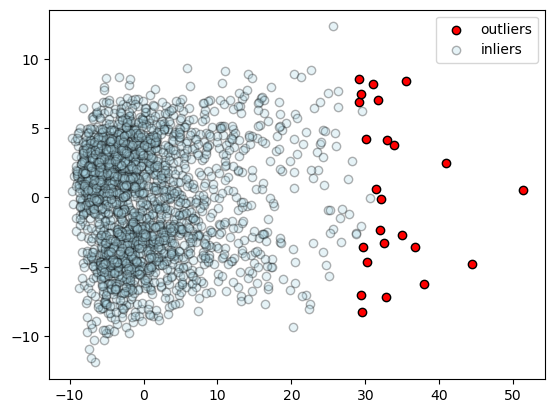

In [116]:
plt.scatter(X_pca[np.where(df.outliers_CBLOF == -1), 0], X_pca[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_CBLOF == 1), 0], X_pca[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

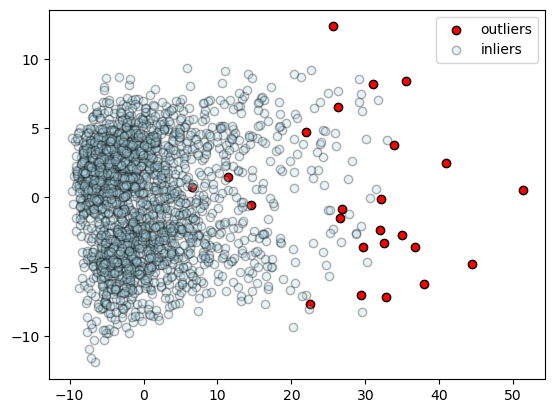

In [117]:
plt.scatter(X_pca[np.where(df.outliers_ABOD == -1), 0], X_pca[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_ABOD == 1), 0], X_pca[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

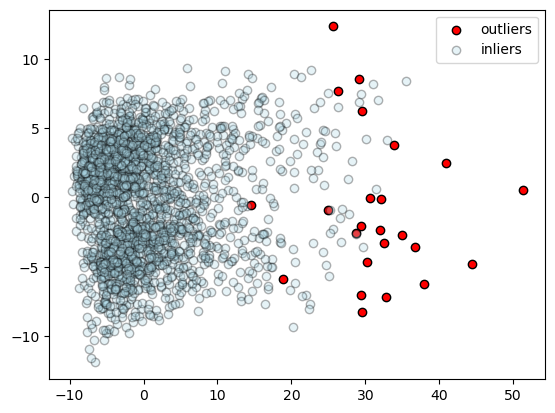

In [118]:
plt.scatter(X_pca[np.where(df.outliers_LODA == -1), 0], X_pca[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_LODA == 1), 0], X_pca[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

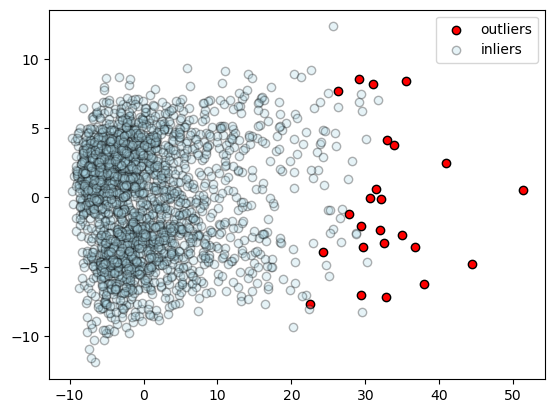

In [119]:
plt.scatter(X_pca[np.where(df.outliers_ISOFOREST == -1), 0], X_pca[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_ISOFOREST == 1), 0], X_pca[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

## Outliers Dropout

In [120]:
df.head()

vocal_channel  emotion  emotional_intensity  statement  sex  frame_count  \
0              0        4                    0          1    0       158558   
1              0        4                    0          1    0       160160   
2              0        4                    0          0    0       156956   
3              0        4                    0          0    0       152152   
4              0        5                    0          1    0       169769   

        sum          mean       std       min  ...  stft_q25_w4  stft_q50_w4  \
0  0.145081  9.150000e-07  0.004001 -0.038422  ...     0.709962     0.799141   
1  0.114319  7.137790e-07  0.004283 -0.042603  ...     0.623183     0.744908   
2  0.149963  9.554485e-07  0.005084 -0.037018  ...     0.643636     0.774253   
3  0.139618  9.176213e-07  0.004886 -0.036652  ...     0.606910     0.755213   
4  0.137665  8.108948e-07  0.002956 -0.026245  ...     0.634815     0.759914   

   stft_q75_w4  stft_kur_w4  stft_skew_w4  outliers_LOF  outliers_CBLOF  \
0     0.896606     6.742190     -1.706215             1               1   
1     0.874713    -0.700420     -0.201495             1               1   
2     0.899156     1.688986     -1.024773             1               1   
3     0.886474    -0.594111     -0.412871             1               1   
4     0.878014     0.126535     -0.620782             1               1   

   outliers_ABOD  outliers_LODA  outliers_ISOFOREST  
0              1              1                   1  
1              1              1                   1  
2              1              1                   1  
3              1              1                   1  
4              1              1                   1  

[5 rows x 382 columns]

In [121]:
df["majority_voting_outlier"] = df.iloc[:,-5:].mode(axis="columns")[0] #majority voting dei 5 outlier score

In [122]:
df.drop(index=df.iloc[np.where(df.majority_voting_outlier == -1)].index) # dataframe privo degli outliers trovati

vocal_channel  emotion  emotional_intensity  statement  sex  \
0                 0        4                    0          1    0   
1                 0        4                    0          1    0   
2                 0        4                    0          0    0   
3                 0        4                    0          0    0   
4                 0        5                    0          1    0   
...             ...      ...                  ...        ...  ...   
2447              1        0                    0          0    1   
2448              1        0                    1          1    1   
2449              1        0                    1          1    1   
2450              1        0                    1          0    1   
2451              1        0                    1          0    1   

      frame_count       sum          mean       std       min  ...  \
0          158558  0.145081  9.150000e-07  0.004001 -0.038422  ...   
1          160160  0.114319  7.137790e-07  0.004283 -0.042603  ...   
2          156956  0.149963  9.554485e-07  0.005084 -0.037018  ...   
3          152152  0.139618  9.176213e-07  0.004886 -0.036652  ...   
4          169769  0.137665  8.108948e-07  0.002956 -0.026245  ...   
...           ...       ...           ...       ...       ...  ...   
2447       219419  0.423157  1.928533e-06  0.014571 -0.094421  ...   
2448       217817 -1.375854 -6.316562e-06  0.025596 -0.219604  ...   
2449       206606  0.573761  2.777078e-06  0.026421 -0.149994  ...   
2450       203404  0.792572  3.896541e-06  0.026456 -0.194244  ...   
2451       213013  0.355530  1.669052e-06  0.034206 -0.233826  ...   

      stft_q50_w4  stft_q75_w4  stft_kur_w4  stft_skew_w4  outliers_LOF  \
0        0.799141     0.896606     6.742190     -1.706215             1   
1        0.744908     0.874713    -0.700420     -0.201495             1   
2        0.774253     0.899156     1.688986     -1.024773             1   
3        0.755213     0.886474    -0.594111     -0.412871             1   
4        0.759914     0.878014     0.126535     -0.620782             1   
...           ...          ...          ...           ...           ...   
2447     0.678422     0.834269    -0.495689     -0.746055             1   
2448     0.544155     0.754146    -0.877851     -0.152447             1   
2449     0.516853     0.729066    -0.997740     -0.003013             1   
2450     0.615354     0.798053    -0.670500     -0.325276             1   
2451     0.654444     0.822547    -0.538011     -0.613433             1   

      outliers_CBLOF  outliers_ABOD  outliers_LODA  outliers_ISOFOREST  \
0                  1              1              1                   1   
1                  1              1              1                   1   
2                  1              1              1                   1   
3                  1              1              1                   1   
4                  1              1              1                   1   
...              ...            ...            ...                 ...   
2447               1              1              1                   1   
2448               1              1              1                   1   
2449               1              1              1                   1   
2450               1              1              1                   1   
2451               1              1              1                   1   

      majority_voting_outlier  
0                           1  
1                           1  
2                           1  
3                           1  
4                           1  
...                       ...  
2447                        1  
2448                        1  
2449                        1  
2450                        1  
2451                        1  

[2436 rows x 383 columns]

In [123]:
#df.to_csv("ravdess_features_outlierless.csv", index=False)

In [124]:
outliers_idx = df.loc[df.majority_voting_outlier == -1].index
outliers_idx

Int64Index([  35,  243,  451,  554,  563,  658,  659, 1031, 1075, 1283, 1861,
            1862, 2024, 2025, 2026, 2027],
           dtype='int64')

In [129]:
len(df_train)

1828

In [155]:
list = [df.drop(columns=df.columns[-6:]).iloc[1861] == df_test.iloc[33]]

True

In [157]:
list = [df.drop(columns=df.columns[-6:]).iloc[1861] == df_test.iloc[33]]
count = 0
for i in range(len(list)):
    if list[0][i] == "False":
        count = count + 1
count

0

In [125]:
print(1861-len(df_train))
print(1862-len(df_train))
print(1966-len(df_train))
print(2024-len(df_train))
print(2025-len(df_train))
print(2026-len(df_train))
print(2027-len(df_train))

33
34
138
196
197
198
199


In [126]:
df.iloc[outliers_idx]

vocal_channel  emotion  emotional_intensity  statement  sex  \
35                0        1                    1          0    0   
243               0        1                    1          0    0   
451               0        1                    1          0    0   
554               0        1                    1          0    1   
563               0        0                    1          0    1   
658               0        1                    1          0    0   
659               0        1                    1          0    0   
1031              1        1                    1          0    1   
1075              0        1                    1          0    0   
1283              0        1                    1          0    0   
1861              0        1                    1          1    0   
1862              0        1                    1          0    0   
2024              1        1                    1          1    1   
2025              1        1                    1          1    1   
2026              1        1                    1          0    1   
2027              1        1                    1          0    1   

      frame_count       sum          mean       std       min  ...  \
35         213013 -9.211029 -4.324163e-05  0.149701 -0.971649  ...   
243        216216 -0.476227 -2.202551e-06  0.104572 -0.944122  ...   
451        174575  0.947906  5.429795e-06  0.109958 -0.938812  ...   
554        213013  0.785797  3.688963e-06  0.091451 -0.633057  ...   
563        179379 -0.203125 -1.132379e-06  0.121231 -0.727966  ...   
658        184184 -6.383972 -3.466084e-05  0.120286 -0.976166  ...   
659        208208  2.806671  1.348013e-05  0.096210 -0.763763  ...   
1031       219420  0.905365  4.126174e-06  0.091933 -0.561218  ...   
1075       180981  8.481720  4.686525e-05  0.104275 -0.939880  ...   
1283       200200 -3.701965 -1.849134e-05  0.152168 -0.970276  ...   
1861       230630  2.317932  1.005044e-05  0.104134 -0.743408  ...   
1862       208208 -0.817017 -3.924040e-06  0.140110 -0.998810  ...   
2024       217818 -0.678925 -3.116935e-06  0.114889 -0.616730  ...   
2025       217817 -0.129700 -5.954526e-07  0.091525 -0.618561  ...   
2026       217818  0.193146  8.867300e-07  0.118097 -0.732819  ...   
2027       219419  0.656555  2.992244e-06  0.108406 -0.730164  ...   

      stft_q50_w4  stft_q75_w4  stft_kur_w4  stft_skew_w4  outliers_LOF  \
35       0.484957     0.751114    -1.098503      0.225204             1   
243      0.629270     0.809098    -0.688100     -0.164156             1   
451      0.598260     0.777178    -0.912299      0.219962             1   
554      0.659654     0.854806    -1.151544     -0.429745             1   
563      0.250091     0.519727    -0.175535      1.000085             1   
658      0.808485     0.929470     0.928971     -1.099596             1   
659      0.877829     0.969386     1.752002     -1.479197             1   
1031     0.485258     0.705538    -0.879540      0.303456             1   
1075     0.639846     0.833141    -0.955430     -0.104207             1   
1283     0.236722     0.456975    -0.232426      1.119447             1   
1861     0.662068     0.843215    -0.823847     -0.488190             1   
1862     0.474520     0.729635    -1.037921      0.325624             1   
2024     0.712763     0.854215    -0.793384     -0.711244             1   
2025     0.521825     0.750513    -0.942620      0.095565             1   
2026     0.511515     0.725642    -0.893517      0.201854             1   
2027     0.374620     0.637012    -0.790393      0.590203             1   

      outliers_CBLOF  outliers_ABOD  outliers_LODA  outliers_ISOFOREST  \
35                -1             -1             -1                  -1   
243               -1             -1             -1                  -1   
451               -1              1             -1                  -1   
554               -1             -1             -1                  -